# Summary

This notebook contains the code necessary to recreate our analysis of the effects of genre and visual enhancements on the total gross income of a movie. 

#### 1. Imports
#### 2. Data Read-In
#### 3. Merges
#### 4. Data Cleaning & Processing
#### 5. Analysis & Graphs
***

## 1. IMPORTS

In [212]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pdb

from cleaning_scripts import *

%matplotlib inline
sns.set_style('darkgrid')

## 2. DATA READ-IN 

In [237]:
basics_df = pd.read_csv('./data/imdb.title.basics.csv.gz')
gross_df = pd.read_csv('./data/bom.movie_gross.csv.gz')
akas_df = pd.read_csv('./data/imdb.title.akas.csv.gz')

final_df = pd.read_csv('./data/final.csv')
final_df.drop(['gross_unscaled'], axis=1, inplace=True)
final_df.to_csv('./data/final.csv')

## 3. MERGES (unnecessary now because of final.csv)

In [228]:
# # basics_df:
# # rename tconst => title_id
# basics_df.rename(columns={'tconst': 'title_id'}, inplace=True)

# # merge basics and akas dfs
# # store in new df => common_id_df
# common_id_df = basics_df.merge(akas_df, on='title_id', how='inner')

# # gross_df:
# # rename title => primary_title
# gross_df.rename(columns={'title': 'primary_title'}, inplace=True)

# # merge common_id and gross dfs
# # store in new df => final_df
# final_df = common_id_df.merge(gross_df, on='primary_title', how='inner')

## 4. DATA CLEANING & PROCESSING

In [229]:
# make sure domestic & foreign gross are both float types
final_df.domestic_gross = pd.to_numeric(final_df.domestic_gross, errors='coerce')
final_df.foreign_gross = pd.to_numeric(final_df.foreign_gross, errors='coerce')

# replace any gross na values with 0.0 (assuming an na means not presented domestically/internationally)
final_df.domestic_gross.fillna(0.0, inplace=True)
final_df.foreign_gross.fillna(0.0, inplace=True)

# add total_gross column, express value in billions
final_df['total_gross'] = final_df.domestic_gross + final_df.foreign_gross
final_df.total_gross = final_df.total_gross / 1_000_000_000

# drop repated movie listings that result in the same total_gross (these are just repeat listings)
unique_titles = final_df.drop_duplicates(subset=['primary_title', 'total_gross'])



### 4b. SUBSET DATAFRAMES


In [230]:
# performant_genres: An ordered listing of the top 10 genre labels with the highest total_gross 
performant_genres = unique_titles.groupby("genres").sum().sort_values('total_gross', ascending=False).iloc[0:10, -1:]

# top subgenres: a cimple count of occurances of subgenres within the top performant genres
#     process subgenres
subgenres = get_subgenres(performant_genres.reset_index().genres)
top_subgenres = subgenre_counter(subgenres, performant_genres.reset_index())
#     Create subgenres dataframe
top_subgenres_df = pd.DataFrame(top_subgenres.items())
top_subgenres_df.columns = ["Genre", "Count"]
top_subgenres_df = top_subgenres_df.sort_values('Count', ascending=False)

# visually_enhanced: subset of movies with visual enhancements (3d or IMAX), grouped by genres
visually_enhanced = final_df[final_df.attributes.isin(['3-D version', 'IMAX version'])].sort_values('total_gross', ascending=False).loc[:, ["primary_title","total_gross"]]
top_visually_enhanced = visually_enhanced.groupby('primary_title').sum().sort_values('total_gross', ascending=False).iloc[:10, -1:]

# special_attributes: final_df grouped by attributes and sorted by total gross
special_attributes = final_df.groupby('attributes').sum().sort_values('total_gross', ascending=False)[0:12]

***
# == CHECKPOINT ==

final_df has all data needed for this analysis  
performant_genres, top_subgenres_df, visual_enhancements, & special_attributes subset for analysis
***

## 5. ANALYSIS & GRAPHS

### Question 1. Towards what genres should Microsoft direct its resources to maximize gross income

***
#### Top grossing genres

In [231]:
performant_genres

,total_gross
genres,
"Action,Adventure,Sci-Fi",27.636100
"Adventure,Animation,Comedy",25.448726
"Action,Adventure,Fantasy",13.314887
"Action,Adventure,Comedy",9.563595
"Action,Adventure,Animation",6.454160
"Action,Adventure,Thriller",6.278398
"Action,Adventure,Drama",4.933278
Comedy,4.477626
"Action,Thriller",3.787685


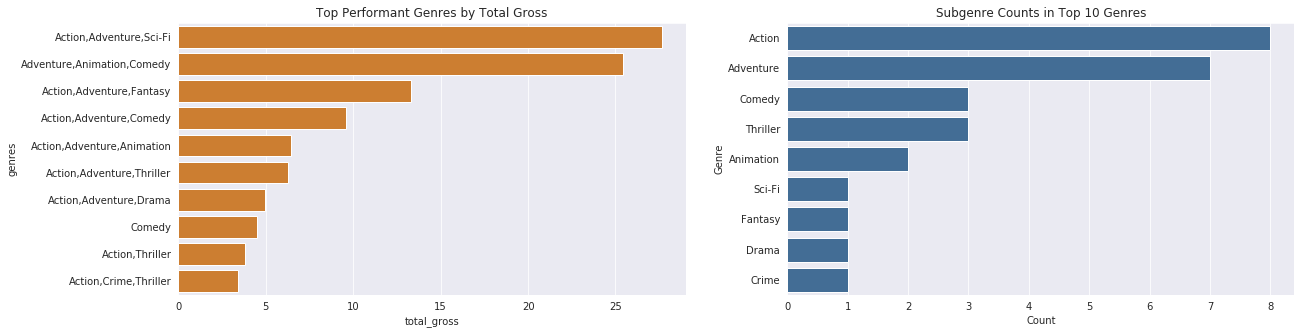

In [236]:
plt.figure(figsize=(20, 5))
ax1 = plt.subplot(121, xlabel="Total Gross")
ax1.set_xlabel("Total Gross (billions)")
ax1.set_ylabel("Total")
ax1.set_title("Top Performant Genres by Total Gross")

ax2 = plt.subplot(122)
ax2.set_title("Subgenre Counts in Top 10 Genres")

sns.barplot(data=performant_genres, y=performant_genres.index, x='total_gross', orient='h', ax=ax1, color="#E67E17")
sns.barplot(data=top_subgenres_df, x="Count", y='Genre', ax=ax2, color="#366DA2")
plt.subplots_adjust(wspace=0.2)
plt.show()

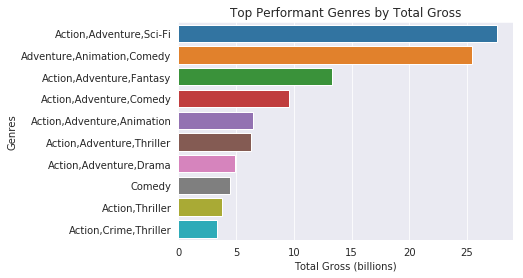

In [235]:


sns.barplot(data=performant_genres, y=performant_genres.index, x='total_gross', orient='h')

plt.title("Top Performant Genres by Total Gross")
plt.xlabel("Total Gross (billions)")
plt.ylabel("Genres")

plt.show()

#### Analysis: 

The above chart shows how well each genre (long form) performed at the boxoffice. From this, we can see that the top two genres, (Action, Adventure, Sci-Fi) & (Adventure, Animation, Comedy) significantly outperformed the other genre categories.  

From a cursory glance, it would appear as if there is a high number of Adventure and Action films in this list. The anecdotal evidence suggests that MS may want to invest its time and efforts in Action/Adventure content to maximize profits.

***
#### Subgenres within performant genres

Text(0.5, 1.0, 'Subgenre Counts from Top 10 Genres')

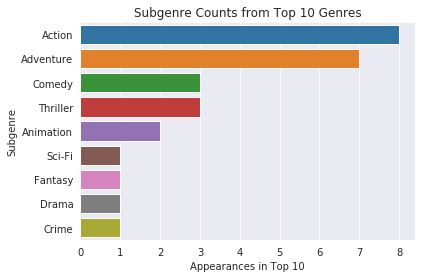

In [200]:
sns.barplot(data=top_subgenres_df, x="Count", y='Genre')
plt.xlabel("Appearances in Top 10")
plt.ylabel("Subgenre")
plt.title("Subgenre Counts from Top 10 Genres")

#### Analysis: 

Further exploration of the subgenres in the top 10 performant genres reveals that our original assumption of the high yieled of action and adventure films was accurate. We can see more clearly with this chart that both action and adeventure subgenres appear more than double the amount of times in the genre listings of the top performant genres.  

Our recommendation holds that MS should direct its resources towards action and adventure movies. 

### Question 2 - Microsoft has become increasingly focused on hardware in the last two decades (xbox, hololens, etc.). How can they leverage their inbuilt technological advantages in their media streaming service? 

Text(0.5, 1.0, 'Top 10 Grossing Movies with Enhanced Visual Element')

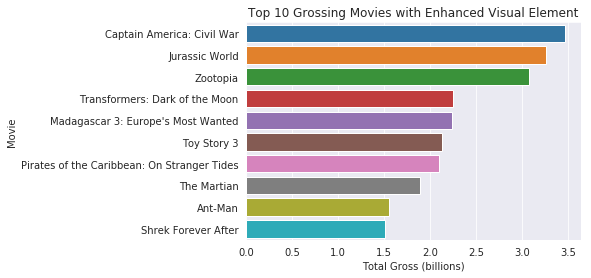

In [142]:
sns.barplot(data=top_visually_enhanced, x='total_gross', y=top_visually_enhanced.index)
plt.ylabel("Movie")
plt.xlabel("Total Gross (billions)")
plt.title("Top 10 Grossing Movies with Enhanced Visual Element")

#### Analysis: 

We believe it is wise for Microsoft to use its existing line of media hardware to help carve a distinguishable path in this crowded product landscape.  

The chart above shows to gross income in billions of the top 10 highest grossing movies that had some visual enhancement (3D or IMAX versions). It is our suggestion that Microsoft use these films as models for further study to create similar productions that could also take advantage of their media technology. 

In [143]:
final_df

,Unnamed: 0,title_id,primary_title,original_title,start_year,runtime_minutes,genres,ordering,title,region,language,types,attributes,is_original_title,studio,domestic_gross,foreign_gross,year,total_gross,gross_unscaled
0,0,tt0315642,Wazir,Wazir,2016,103.0,"Action,Crime,Drama",1,Wazir,NaN,NaN,original,NaN,1.0,Relbig.,1100000.0,0.0,2016,1.100000e-03,1100000.0
1,1,tt0315642,Wazir,Wazir,2016,103.0,"Action,Crime,Drama",2,64 Squares,NaN,NaN,NaN,NaN,0.0,Relbig.,1100000.0,0.0,2016,1.100000e-03,1100000.0
2,2,tt0315642,Wazir,Wazir,2016,103.0,"Action,Crime,Drama",3,Wazir,IN,NaN,NaN,NaN,0.0,Relbig.,1100000.0,0.0,2016,1.100000e-03,1100000.0
3,3,tt0315642,Wazir,Wazir,2016,103.0,"Action,Crime,Drama",4,Move 5,IN,en,working,NaN,0.0,Relbig.,1100000.0,0.0,2016,1.100000e-03,1100000.0
4,4,tt0315642,Wazir,Wazir,2016,103.0,"Action,Crime,Drama",5,The Last Square,IN,en,working,NaN,0.0,Relbig.,1100000.0,0.0,2016,1.100000e-03,1100000.0
5,5,tt0315642,Wazir,Wazir,2016,103.0,"Action,Crime,Drama",6,Ферзь,RU,NaN,NaN,NaN,0.0,Relbig.,1100000.0,0.0,2016,1.100000e-03,1100000.0
6,6,tt0337692,On the Road,On the Road,2012,124.0,"Adventure,Drama,Romance",10,En el camino,AR,NaN,imdbDisplay,NaN,0.0,IFC,744000.0,8000000.0,2012,8.744000e-03,8744000.0
7,7,tt0337692,On the Road,On the Road,2012,124.0,"Adventure,Drama,Romance",11,On the Road - Unterwegs,DE,NaN,imdbDisplay,NaN,0.0,IFC,744000.0,8000000.0,2012,8.744000e-03,8744000.0
8,8,tt0337692,On the Road,On the Road,2012,124.0,"Adventure,Drama,Romance",12,Na Estrada,BR,NaN,imdbDisplay,NaN,0.0,IFC,744000.0,8000000.0,2012,8.744000e-03,8744000.0
9,9,tt0337692,On the Road,On the Road,2012,124.0,"Adventure,Drama,Romance",13,W drodze,PL,NaN,imdbDisplay,NaN,0.0,IFC,744000.0,8000000.0,2012,8.744000e-03,8744000.0


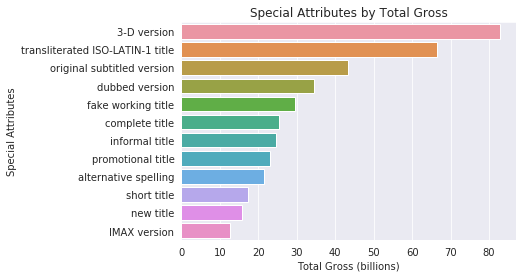

In [144]:
g = sns.barplot(data=special_attributes, x='total_gross', y=special_attributes.index)

# for i, r in special_attributes.iterrows():
#     g.text(s=round(r.total_gross, 2), x=r.name, y=r.tip)

plt.title("Special Attributes by Total Gross")
plt.xlabel("Total Gross (billions)")
plt.ylabel("Special Attributes")

plt.show()

#### Analysis: 

To further support our previous recommendation, we present the above graph. From it, we can see that the special attribute that accounts for the highest total gross is 3D visual enhancement at over 80 billion dollars. While IMAX versions are not so proffitable, they are ranked 12th on the list, and account for more than 10 billion dollars.  

Given these results, our recommendation stands that there is substantial opportunity for profit in visually enhanced projects, and that Microsoft is in a unique position to offer groundbreaking viewing experiences in this area. 

In [145]:
special_attributes.head()

,Unnamed: 0,start_year,runtime_minutes,ordering,is_original_title,domestic_gross,foreign_gross,year,total_gross,gross_unscaled
attributes,,,,,,,,,,
3-D version,4572522,348546,19378.0,3167,0.0,3.181957e+10,5.113838e+10,348554,82.957956,8.295796e+10
transliterated ISO-LATIN-1 title,8340814,837091,45443.0,7129,0.0,2.565936e+10,4.088712e+10,837166,66.546477,6.654648e+10
original subtitled version,14622779,868462,47285.0,6193,0.0,1.822751e+10,2.505882e+10,868547,43.286334,4.328633e+10
dubbed version,3705559,328101,16678.0,2392,0.0,1.214369e+10,2.232917e+10,328136,34.472856,3.447286e+10
fake working title,1288256,116779,7172.0,952,0.0,1.254795e+10,1.708879e+10,116780,29.636739,2.963674e+10


In [146]:
three_d = final_df[final_df.attributes == '3-D version']
split_3d = three_d
three_d_per_year = three_d.groupby('year').size()
three_d = three_d.groupby('year').sum()
three_d['films_per_year'] = three_d_per_year

three_d['gross_by_num_films'] = three_d.total_gross / three_d.films_per_year

three_d

# imax = final_df[final_df.attributes == 'IMAX version']

# imax = imax.groupby('year').sum()

# imax

,Unnamed: 0,start_year,runtime_minutes,ordering,is_original_title,domestic_gross,foreign_gross,total_gross,gross_unscaled,films_per_year,gross_by_num_films
year,,,,,,,,,,,
2010,55592,18090,821.0,239,0.0,9.970000e+08,1.755100e+09,2.752100,2.752100e+09,9,0.305789
2011,138208,30165,1633.0,300,0.0,1.908900e+09,4.616900e+09,6.525800,6.525800e+09,15,0.435053
2012,185044,26154,1229.0,246,0.0,1.590378e+09,3.912282e+09,5.502660,5.502660e+09,13,0.423282
2013,142618,24156,1452.0,217,0.0,2.728100e+09,4.698800e+09,7.426900,7.426900e+09,12,0.618908
2014,415326,30210,1686.0,224,0.0,2.168392e+09,4.750400e+09,6.918792,6.918792e+09,15,0.461253
2015,680824,60450,3425.0,523,0.0,7.350413e+09,6.836600e+09,14.187013,1.418701e+10,30,0.472900
2016,1199518,66528,3761.0,599,0.0,6.432475e+09,1.089140e+10,17.323875,1.732388e+10,33,0.524966
2017,1052481,58489,3373.0,546,0.0,4.916700e+09,8.743600e+09,13.660300,1.366030e+10,29,0.471045
2018,702911,34304,1998.0,273,0.0,3.727216e+09,4.933300e+09,8.660516,8.660516e+09,17,0.509442


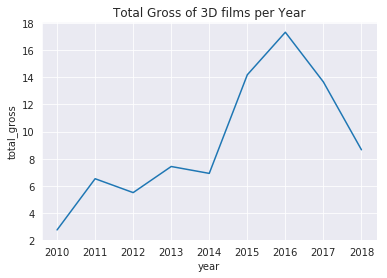

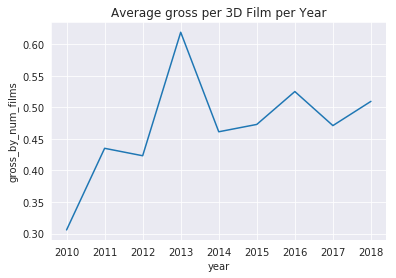

In [147]:
sns.lineplot(data=three_d.reset_index(), x='year', y='total_gross')
plt.title("Total Gross of 3D films per Year")
plt.show()
sns.lineplot(data=three_d.reset_index(), x='year', y='gross_by_num_films')
plt.title("Average gross per 3D Film per Year")
plt.show()

#### Analysis: 

(2nd graph)

Besides an anomalous spike in generated revenue in 2013, 3D films have experience a significant rise in gross profits since 2010, and have been holding relatively steady for the last 4 years. Given this trend and perceived staying power, the recommendation holds that Microsoft look into ways to use their proprietary technology to visually enhance their productions. 

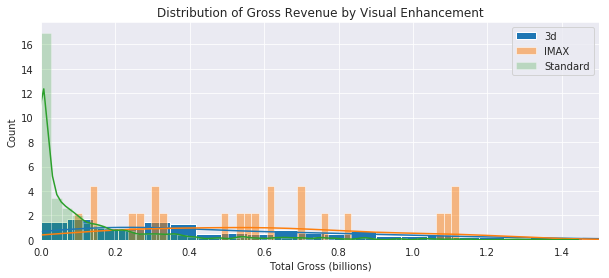

In [194]:

imax = final_df[final_df.attributes == 'IMAX version']
imax = imax.groupby('primary_title').sum()

f = plt.figure(figsize=(10, 4))

split_3d = split_3d.groupby('primary_title').sum()

sns.distplot(a=split_3d.total_gross, bins=50, hist_kws=dict(alpha=1))
sns.distplot(a=imax.total_gross, bins=50, hist_kws=dict(alpha=0.5))
sns.distplot(a=final_df.total_gross, bins=50, hist_kws=dict(alpha=0.25))

plt.legend(['3d', 'IMAX', "Standard"])

plt.xlabel("Total Gross (billions)")
plt.ylabel('Count')
plt.xlim([0, 1.5])
plt.title("Distribution of Gross Revenue by Visual Enhancement")
plt.show()

In [156]:
final_df.sort_values('total_gross')

,Unnamed: 0,title_id,primary_title,original_title,start_year,runtime_minutes,genres,ordering,title,region,language,types,attributes,is_original_title,studio,domestic_gross,foreign_gross,year,total_gross,gross_unscaled
29720,29720,tt1986953,Storage 24,Storage 24,2012,87.0,"Action,Horror,Mystery",1,Хранилище 24,RU,NaN,NaN,NaN,0.0,Magn.,100.0,0.0,2013,1.000000e-07,1.000000e+02
29724,29724,tt1986953,Storage 24,Storage 24,2012,87.0,"Action,Horror,Mystery",5,Ladu 24,EE,NaN,imdbDisplay,NaN,0.0,Magn.,100.0,0.0,2013,1.000000e-07,1.000000e+02
29723,29723,tt1986953,Storage 24,Storage 24,2012,87.0,"Action,Horror,Mystery",4,Storage 24,NaN,NaN,original,NaN,1.0,Magn.,100.0,0.0,2013,1.000000e-07,1.000000e+02
29722,29722,tt1986953,Storage 24,Storage 24,2012,87.0,"Action,Horror,Mystery",3,Storage 24,GB,NaN,NaN,NaN,0.0,Magn.,100.0,0.0,2013,1.000000e-07,1.000000e+02
29721,29721,tt1986953,Storage 24,Storage 24,2012,87.0,"Action,Horror,Mystery",2,Korku Kapani,TR,tr,imdbDisplay,NaN,0.0,Magn.,100.0,0.0,2013,1.000000e-07,1.000000e+02
49790,49790,tt4796122,Satanic,Satanic,2016,85.0,Horror,1,Satanic,NaN,NaN,original,NaN,1.0,Magn.,300.0,0.0,2016,3.000000e-07,3.000000e+02
54716,54716,tt8331988,The Chambermaid,La camarista,2018,102.0,Drama,6,La camarista,NaN,NaN,original,NaN,1.0,FM,300.0,0.0,2015,3.000000e-07,3.000000e+02
54715,54715,tt8331988,The Chambermaid,La camarista,2018,102.0,Drama,5,La camarista,MX,NaN,NaN,NaN,0.0,FM,300.0,0.0,2015,3.000000e-07,3.000000e+02
54714,54714,tt8331988,The Chambermaid,La camarista,2018,102.0,Drama,4,Kambarine,LT,NaN,imdbDisplay,NaN,0.0,FM,300.0,0.0,2015,3.000000e-07,3.000000e+02
54713,54713,tt8331988,The Chambermaid,La camarista,2018,102.0,Drama,3,La camarista,FR,NaN,imdbDisplay,NaN,0.0,FM,300.0,0.0,2015,3.000000e-07,3.000000e+02


In [51]:
enhanced_attributes = final_df[final_df.attributes.str.contains("title|alt|promo")==False]
enhanced_attributes.attributes.value_counts()

3-D version                173
dubbed version             163
IMAX version                22
director's cut               5
cut version                  5
recut version                4
longer version               3
short version                2
correct transliteration      1
Name: attributes, dtype: int64

In [55]:
enhanced_attributes = enhanced_attributes.groupby('attributes').sum().sort_values('total_gross', ascending=False)

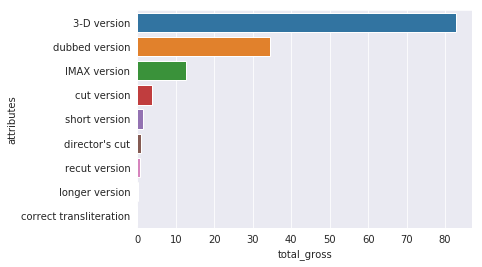

In [105]:
sns.barplot(data=enhanced_attributes, x='total_gross', y=enhanced_attributes.index)
plt.xticks(rotation=0.5)
plt.show()

#### Analysis: 

When you get rid of all the bogus attributes listed, you can see that 3d versions far out perform other attributes. IMAX also lands in the top 3 with a total revenue of over 10 billion dollars